# Classifying Titanic with different Nodels

### 載入資料

In [87]:
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib

# date process
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# machine learning
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier

# 關 warning
import warnings
warnings.filterwarnings('ignore')

In [88]:
import seaborn as sns
df = sns.load_dataset("titanic")
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [90]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

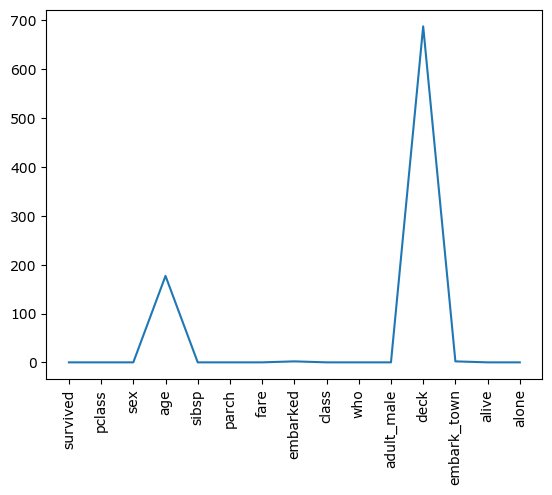

In [91]:
# plot missing values for each variable
df.isnull().sum().plot()
columns = df.columns
plt.xticks(np.arange(len(columns)), columns, rotation='vertical');

### 資料處理

In [92]:
# age 欄位的 NAN 取中位數
df["age"] = df["age"].fillna(df["age"].median())

# Cabin 無效資料過多，embarked, deck, who, alive, alone, class 重複或無意義，刪除欄位
df.drop(columns=["embarked","deck","who","alive","alone","class"], inplace=True)

### sex 欄位和 adult_male 欄位 數字化並合併

In [93]:
df['sex'].unique()

array(['male', 'female'], dtype=object)

In [94]:
df["adult_male"].unique()

array([ True, False])

In [95]:
# sex 欄位和 adult_male 欄位 數字化並合併
# 0 成年男性
# 1 未成年男性
# 2 女性
for i in range(0,len(df["sex"])):
    if df["sex"][i] == "male":
        if df["adult_male"][i]:
            df["sex"][i] = 0
        else:
            df["sex"][i] = 1
    else:
        df["sex"][i] = 2

# 刪除 male_adult 欄位
df.drop(columns=["adult_male"], inplace=True)

### 其他object欄位處理

In [96]:
# 先用 ffill() 處理 nan
df["embark_town"]= df["embark_town"].ffill()
# embark_town 欄位 ohe
ohe = OneHotEncoder()
Xn = ohe.fit_transform(df["embark_town"].values.reshape(-1, 1)).toarray()
# column process
ohe_list = np.sort("from_"+df["embark_town"].unique())
dfn = pd.DataFrame(Xn, columns=ohe_list)
# combine
df = pd.concat((df.drop("embark_town", axis=1), dfn), axis=1)

In [97]:
df

,survived,pclass,sex,age,sibsp,parch,fare,from_Cherbourg,from_Queenstown,from_Southampton
0,0,3,0,22.0,1,0,7.2500,0.0,0.0,1.0
1,1,1,2,38.0,1,0,71.2833,1.0,0.0,0.0
2,1,3,2,26.0,0,0,7.9250,0.0,0.0,1.0
3,1,1,2,35.0,1,0,53.1000,0.0,0.0,1.0
4,0,3,0,35.0,0,0,8.0500,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,0.0,0.0,1.0
887,1,1,2,19.0,0,0,30.0000,0.0,0.0,1.0
888,0,3,2,28.0,1,2,23.4500,0.0,0.0,1.0
889,1,1,0,26.0,0,0,30.0000,1.0,0.0,0.0


In [98]:
df.describe()

,survived,pclass,age,sibsp,parch,fare,from_Cherbourg,from_Queenstown,from_Southampton
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208,0.189675,0.087542,0.722783
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429,0.392264,0.282787,0.447876
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


## 資料分割

In [99]:
df1 = df.copy()
Y=df1["survived"]
del df1["survived"]

In [100]:
X_train, X_test, Y_train, Y_test= train_test_split(df1, Y, test_size=0.2)

# Logistic Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 3)
acc_log

# 模型訓練

In [101]:
dict_classifiers = {
        "Gradient Boosting Classifier": 
            {'classifier': GradientBoostingClassifier(),
                 'params': [
                            {
                             'learning_rate': [0.1, 0.3, 0.5],
                             'n_estimators' :[10,20,30],
                             'max_depth':[3,5]
                            }
                           ]
            },
    "Logistic Regression": 
            {'classifier': LogisticRegression(),
                'params' : [
                            {
                             'penalty': ['l1','l2'],
                             'C': [0.01,0.1,1,10,100]
                            }
                           ]
            },
    "Nearest Neighbors": 
            {'classifier': KNeighborsClassifier(),
                 'params': [
                            {
                            'n_neighbors': [1, 3, 5, 10],
                            'leaf_size': [3, 5, 10]
                            }
                           ]
            },
    "Decision Tree":
            {'classifier': tree.DecisionTreeClassifier(),
                 'params': [
                            {
                             'max_depth':[3,5]
                            }
                             ]
            },
    "Random Forest": 
            {'classifier': RandomForestClassifier(),
                 'params': {}
            },
    "Naive Bayes": 
            {'classifier': GaussianNB(),
                 'params': {}
            } #,         
#    "Linear SVM": 
#            {'classifier': SVC(),
#                 'params': [
#                            {
#                             'C': [1, 10],
#                             'gamma': [0.001, 0.00001],
#                             'kernel': ['linear']
#                            }
#                          ]
#            }
}

In [102]:
from sklearn.model_selection import learning_curve 
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.6, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,shuffle=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

    # 存檔
    plt.savefig(title+".png")
    return plt


In [103]:
import time
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score
num_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, Y_train, X_test, Y_test, verbose = True):
    df_results = pd.DataFrame(
        data=np.zeros(shape=(num_classifiers,4)),
        columns = ['classifier',
                   'train_score', 
                   'test_score',
                   'training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.time()
        grid = GridSearchCV(classifier['classifier'], 
                      classifier['params'],
                      refit=True,
                        cv = 10, 
                        scoring = 'accuracy', # scoring metric
                        n_jobs = -1
                        )
        estimator = grid.fit(X_train,
                             Y_train)
        t_end = time.time()
        t_diff = t_end - t_start
        train_score = estimator.score(X_train,
                                      Y_train)
        test_score = estimator.score(X_test,
                                     Y_test)

        bst=grid.best_params_
        
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'test_score'] = test_score
        df_results.loc[count,'training_time'] = t_diff
        
        if verbose:
            print("({n}/{m}) {c} trained in {f:.2f} s ".format(c=key, f=t_diff, n=count+1, m=num_classifiers))
            print("      Parameters: ",bst)
            print(" ")

            # 儲存best model
            joblib.dump(grid.best_estimator_,"./models/"+key+".joblib")     
        
        count+=1
        plot_learning_curve(estimator, 
                              "{}".format(key),
                              X_train,
                              Y_train,
                              ylim=(0.75,1.0),
                              cv=10)
    return df_results

(1/6) Gradient Boosting Classifier trained in 1.80 s 
      Parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 20}
 
(2/6) Logistic Regression trained in 0.60 s 
      Parameters:  {'C': 10, 'penalty': 'l2'}
 
(3/6) Nearest Neighbors trained in 0.66 s 
      Parameters:  {'leaf_size': 5, 'n_neighbors': 10}
 
(4/6) Decision Tree trained in 0.08 s 
      Parameters:  {'max_depth': 3}
 
(5/6) Random Forest trained in 0.77 s 
      Parameters:  {}
 
(6/6) Naive Bayes trained in 0.06 s 
      Parameters:  {}
 
                     classifier  train_score  test_score  training_time
0  Gradient Boosting Classifier     0.830056    0.865922       1.796751
3                 Decision Tree     0.825843    0.865922       0.078156
4                 Random Forest     0.983146    0.865922       0.766835
1           Logistic Regression     0.808989    0.854749       0.604646
5                   Naive Bayes     0.787921    0.815642       0.062495
2             Nearest Neighbors     0.75

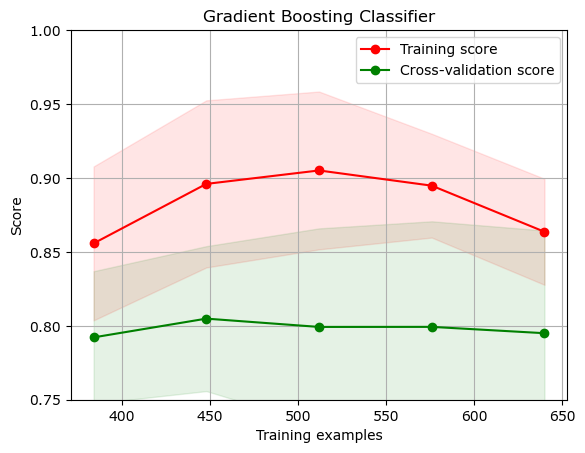

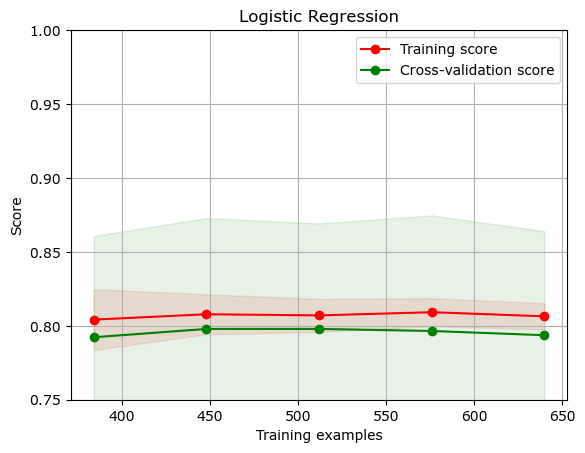

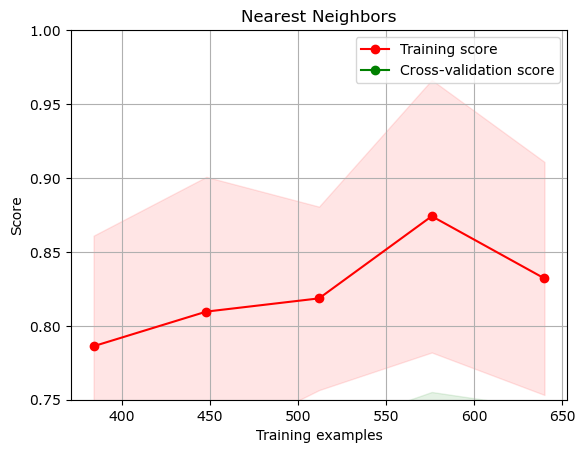

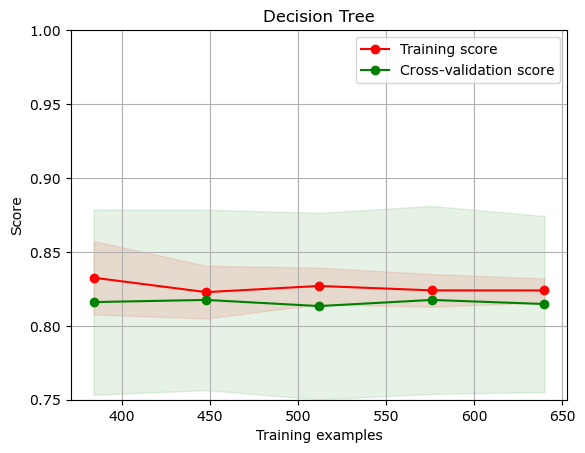

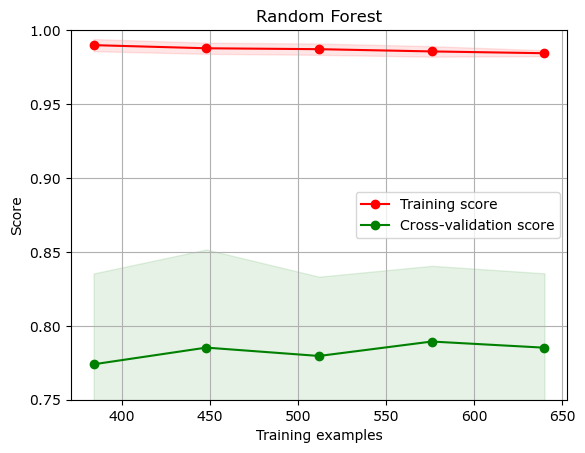

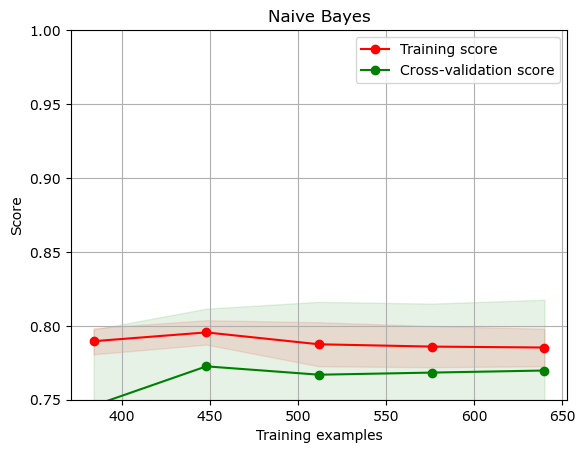

In [104]:
df_results = batch_classify(X_train, Y_train, X_test, Y_test)
print(df_results.sort_values(by='test_score', ascending=False))

# 結論

1. 最佳模型為 Gradient Boosting Classifier，實測分數 0.86
2. 因為只要使用到SVM，程式就會卡住，但卻不會出現error或warning，因此最後把SVM取消了
